In [2]:
import tensorflow as tf

In [3]:
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [10]:
IMAGE_SIZE = 256 # as images are 256x256 in size
BATCH_SIZE = 32 # standard batch size
CHANNELS = 3 # 3 cols: RGB
EPOCHS = 50

In [11]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    "Potatos",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [18]:
class_names = data.class_names

In [14]:
# number of batches:
len(data)

68

# Visualizing some 12 of each class picking randomly

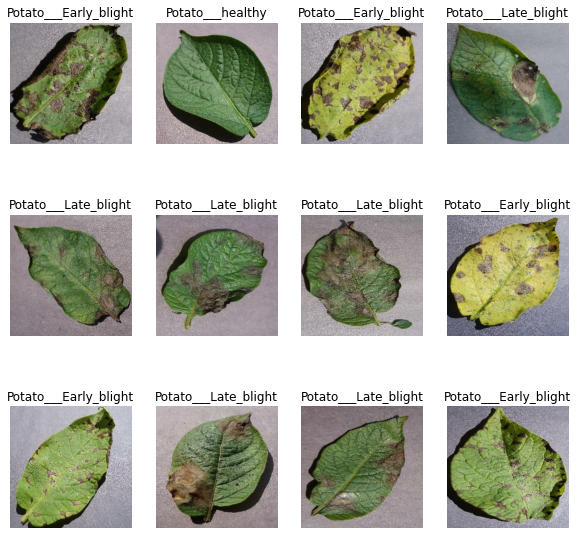

In [19]:
plt.figure(figsize = (10, 10))
for image_batch, label_batch in data.take(1): # take(1) = [:1] of entire dataset
    for i in range(12): # seeing 12 images, bcz perfect fit in screen
        ax = plt.subplot(3, 4, i+1) # plotting all 12 images
        plt.imshow(image_batch[i].numpy().astype("uint8")) # float to int
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

# Train-Validate-test split

we want 80% => train
rest 20% => 10% validation, 10% test

also, since there's no such thing like train_test_split() as we had in sklearn
hence we have to do it manualy

In [21]:
def get_dataset_partitions(data, train_split=0.8, val_split=0.1, test_split=0.1, shuffle = True, shuffle_size = 100):
    ds_size = len(data)
    
    if(shuffle):
        data = data.shuffle(shuffle_size, seed=12) # seed used to get consistent results on every run
        
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)
    
    train_data = data.take(train_size) # [:54]
    
    val_data = data.skip(train_size).take(val_size) # [54:6]
    test_data = data.skip(train_size).skip(val_size) #[60:]

    return train_data, val_data, test_data

In [22]:
train_ds, val_ds, test_ds = get_dataset_partitions(data)

In [23]:
len(train_ds)

54

In [24]:
len(val_ds)

6

In [25]:
len(test_ds)

8

Now caching and using prefetching to reduce time for computation

cache() -> stores the images in the ram, so that at every epoch out machine doesnt have to again-and-again read the same image from the disk

prefetch() -> assigns Reading task for the next batch to the CPU, while GPU is training the current batch

In [26]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE) # letting tf decide how many batches to be assinged to cpu
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

## What if there's an image which isn't of size 256x256?
## Hence, adding an image rescaling layer.
## also rescaling all 256x256 images

In [27]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

# Data Augmentation Layer 

In [28]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

in this, we recreate existing dataset with new style, ex: rotating it, or reducing/increasing the contrast, changing lighting; by doing so we increase our training dataset and make model more robust and prevent overfitting